# Chương 6: Phân tích Thành phần chính (PCA) và Giảm chiều dữ liệu

**Mục tiêu:** Biến đổi một tập hợp lớn các biến có tương quan với nhau thành một tập hợp nhỏ hơn các biến không tương quan (gọi là các thành phần chính - Principal Components), trong khi vẫn giữ lại tối đa lượng thông tin ban đầu.

---

## 6.1. Dẫn nhập: Tại sao cần Giảm chiều?

### Case Study: Xây dựng "Chỉ số Sức khỏe Tài chính"
Bạn là một chuyên gia phân tích rủi ro. Bạn có báo cáo tài chính của 1.000 doanh nghiệp với 20 chỉ số khác nhau: Tỷ số thanh toán nhanh, Tỷ số thanh toán hiện hành, ROA, ROE, ROS, Vòng quay hàng tồn kho, Dư nợ trên Vốn chủ sở hữu, v.v...

**Vấn đề:**
1.  **Quá tải thông tin:** Bạn không thể nhìn vào 20 con số cùng lúc để kết luận doanh nghiệp nào tốt.
2.  **Đa cộng tuyến:** ROA và ROE thường biến động cùng chiều. Nếu đưa cả hai vào mô hình hồi quy, kết quả sẽ bị sai lệch.

**Giải pháp:** Thay vì dùng 20 biến, liệu chúng ta có thể nén chúng lại thành 2 chỉ số tổng hợp duy nhất: 
* **Chỉ số 1 (PC1):** Đại diện cho "Khả năng sinh lời".
* **Chỉ số 2 (PC2):** Đại diện cho "Khả năng thanh toán".

Đó chính là nhiệm vụ của **PCA (Principal Component Analysis)**.

## 6.2. Cơ sở Toán học và Hình học của PCA

### 6.2.1. Tư duy hình học
Hãy tưởng tượng dữ liệu của bạn là một đám mây điểm hình bầu dục.
* PCA thực chất là việc **xoay trục tọa độ**.
* Trục đầu tiên (PC1) sẽ được xoay sao cho nó đi qua chiều dài nhất của đám mây (nơi dữ liệu biến thiên mạnh nhất).
* Trục thứ hai (PC2) sẽ vuông góc với PC1 và đi qua chiều rộng của đám mây.

### 6.2.2. Toán học (Eigenvalues & Eigenvectors)
* **Vectơ riêng (Eigenvectors):** Chính là hướng của các trục mới (PC1, PC2...).
* **Giá trị riêng (Eigenvalues - $\lambda$):** Đại diện cho phương sai (lượng thông tin) mà trục đó nắm giữ. $\lambda$ càng lớn, thành phần đó càng quan trọng.

### 6.2.3. Điều kiện tiên quyết: Chuẩn hóa (Standardization)
PCA cực kỳ nhạy cảm với đơn vị đo. 
* Biến "Doanh thu" (đơn vị Tỷ đồng) có phương sai rất lớn.
* Biến "ROA" (đơn vị %) có phương sai rất nhỏ.
Nếu không chuẩn hóa (đưa về cùng Z-score), PCA sẽ bị Doanh thu chi phối hoàn toàn và bỏ qua ROA. **Bắt buộc phải dùng StandardScaler trước khi chạy PCA.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- BƯỚC 1: GIẢ LẬP DỮ LIỆU TÀI CHÍNH ---
np.random.seed(42)
n_companies = 200

# Giả lập 5 chỉ số tài chính (có tương quan với nhau)
# Nhóm Sinh lời: ROA, ROE, NetMargin (Tương quan cao)
roa = np.random.normal(5, 2, n_companies)
roe = roa * 1.5 + np.random.normal(0, 1, n_companies)
margin = roa * 0.8 + np.random.normal(0, 0.5, n_companies)

# Nhóm Thanh khoản: CurrentRatio, QuickRatio (Tương quan cao)
current_ratio = np.random.normal(2, 0.5, n_companies)
quick_ratio = current_ratio * 0.8 + np.random.normal(0, 0.2, n_companies)

# Tạo DataFrame
df_fin = pd.DataFrame({
    'ROA': roa, 'ROE': roe, 'NetMargin': margin, 
    'CurrentRatio': current_ratio, 'QuickRatio': quick_ratio
})

print("Dữ liệu gốc (5 dòng đầu):")
print(df_fin.head())

Dữ liệu gốc (5 dòng đầu):
        ROA        ROE  NetMargin  CurrentRatio  QuickRatio
0  5.993428   9.347930   3.997529      2.378494    2.090452
1  4.723471   7.645992   3.479090      1.538917    1.127925
2  6.295377  10.526117   5.038924      2.434803    1.967067
3  8.046060  13.122892   6.460338      2.677819    2.049800
4  4.531693   5.419871   3.400322      2.206717    1.678475


## 6.3. Thực hành PCA trên Python

Quy trình chuẩn:
1.  StandardScaler.
2.  Fit PCA.
3.  Chọn số lượng thành phần (Scree Plot).
4.  Phân tích trọng số (Loadings) để đặt tên.

In [2]:
# --- BƯỚC 2: CHUẨN HÓA DỮ LIỆU ---
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_fin)

# --- BƯỚC 3: CHẠY PCA ---
# Khởi tạo PCA (chưa giới hạn số lượng component để xem xét toàn bộ)
pca = PCA()
pca.fit(df_scaled)

# --- BƯỚC 4: QUYẾT ĐỊNH GIỮ LẠI BAO NHIÊU COMPONENT? ---
# Tiêu chuẩn 1: Kaiser (Eigenvalue > 1)
eigenvalues = pca.explained_variance_
print("Eigenvalues:", eigenvalues)

# Tiêu chuẩn 2: Cumulative Variance (Phương sai tích lũy > 70-80%)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\nTỷ lệ phương sai được giải thích bởi từng PC:", explained_variance_ratio)
print("Phương sai tích lũy:", cumulative_variance)

Eigenvalues: [2.88739693 1.91614717 0.10569659 0.0799756  0.03590932]

Tỷ lệ phương sai được giải thích bởi từng PC: [0.57459199 0.38131329 0.02103362 0.01591515 0.00714595]
Phương sai tích lũy: [0.57459199 0.95590528 0.9769389  0.99285405 1.        ]


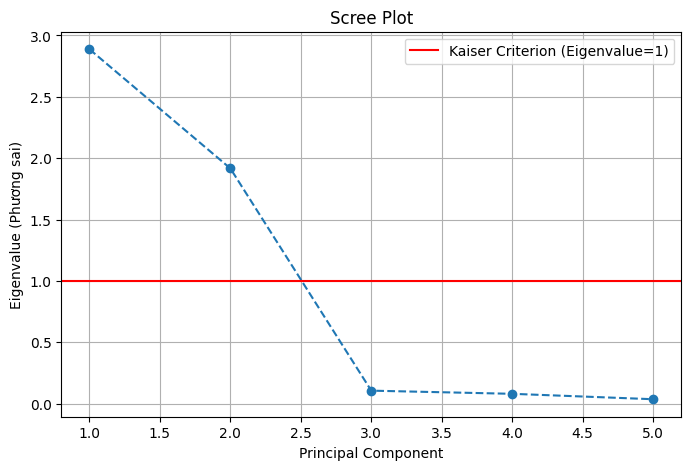

In [3]:
# Vẽ biểu đồ Scree Plot (Biểu đồ khuỷu tay)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), eigenvalues, marker='o', linestyle='--')
plt.axhline(y=1, color='r', linestyle='-', label='Kaiser Criterion (Eigenvalue=1)')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Phương sai)')
plt.legend()
plt.grid()
plt.show()

# NHẬN XÉT:
# Nhìn biểu đồ, ta thấy 2 thành phần đầu tiên có Eigenvalue > 1 và dốc nhất.
# PC1 và PC2 giải thích được gần như toàn bộ thông tin (hơn 90%).
# -> Quyết định giữ lại 2 Components.

### 6.3.2. Phân tích Trọng số (Loadings) và Đặt tên
Đây là bước quan trọng để hiểu PC1 thực sự là gì. PCA chỉ đưa ra con số vô hồn, con người phải thổi hồn (ý nghĩa) vào nó.

Trọng số (Loadings) của 2 thành phần chính:
                   PC1       PC2
ROA           0.579806 -0.073642
ROE           0.566335 -0.105722
NetMargin     0.571097 -0.045206
CurrentRatio  0.099820  0.698763
QuickRatio    0.083507  0.702201


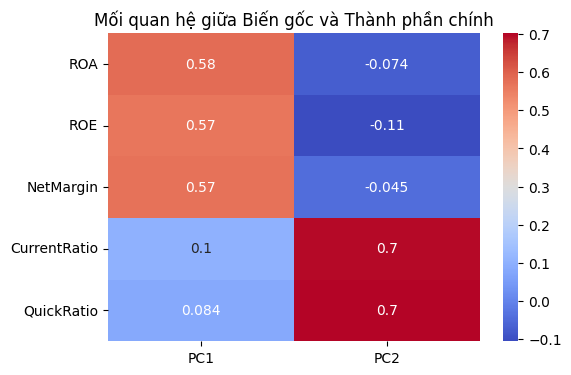

In [4]:
# Lấy trọng số (Loadings)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=df_fin.columns)

# Hiển thị 2 PC đầu tiên
print("Trọng số (Loadings) của 2 thành phần chính:")
print(loadings[['PC1', 'PC2']])

# Vẽ Heatmap cho dễ nhìn
plt.figure(figsize=(6, 4))
sns.heatmap(loadings[['PC1', 'PC2']], annot=True, cmap='coolwarm')
plt.title('Mối quan hệ giữa Biến gốc và Thành phần chính')
plt.show()

**Diễn giải kết quả:**
* **PC1:** Có hệ số tải cao (màu đỏ đậm) ở `ROA`, `ROE`, `NetMargin`. $\rightarrow$ Đặt tên PC1 là **"Chỉ số Hiệu quả Sinh lời"**.
* **PC2:** Có hệ số tải cao ở `CurrentRatio`, `QuickRatio`. $\rightarrow$ Đặt tên PC2 là **"Chỉ số Thanh khoản"**.

Vậy là từ 5 biến, ta đã rút gọn xuống còn 2 biến có ý nghĩa rất rõ ràng.

In [5]:
# --- BƯỚC 5: BIẾN ĐỔI DỮ LIỆU (TRANSFORMATION) ---
# Tính điểm số (Scores) cho từng công ty trên hệ tọa độ mới
pca_final = PCA(n_components=2)
pca_scores = pca_final.fit_transform(df_scaled)

# Tạo DataFrame kết quả
df_pca = pd.DataFrame(pca_scores, columns=['Profitability_Index', 'Liquidity_Index'])

# Ghép vào dữ liệu gốc để so sánh
df_final = pd.concat([df_fin, df_pca], axis=1)
print("Dữ liệu sau khi giảm chiều (5 dòng đầu):")
print(df_final.head())

Dữ liệu sau khi giảm chiều (5 dòng đầu):
        ROA        ROE  NetMargin  CurrentRatio  QuickRatio  \
0  5.993428   9.347930   3.997529      2.378494    2.090452   
1  4.723471   7.645992   3.479090      1.538917    1.127925   
2  6.295377  10.526117   5.038924      2.434803    1.967067   
3  8.046060  13.122892   6.460338      2.677819    2.049800   
4  4.531693   5.419871   3.400322      2.206717    1.678475   

   Profitability_Index  Liquidity_Index  
0             0.880554         1.080287  
1            -0.362864        -1.362483  
2             1.579632         0.892115  
3             3.212230         1.145161  
4            -0.639852         0.451399  


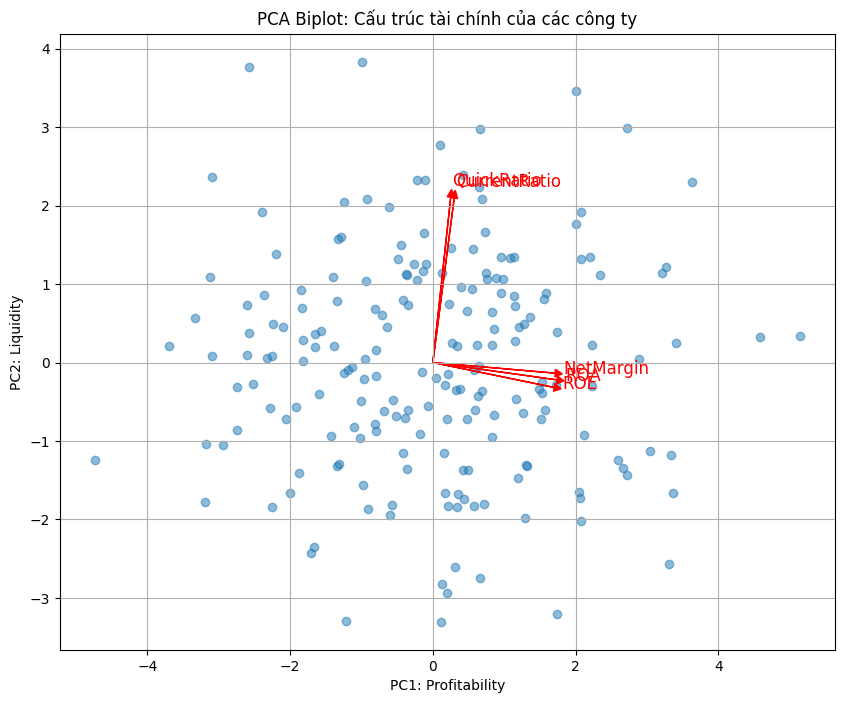

In [6]:
# --- BƯỚC 6: BIPLOT (Biểu đồ 2 chiều) ---
# Biểu diễn cả các điểm dữ liệu (Scores) và các vectơ biến (Loadings) trên cùng 1 hình

plt.figure(figsize=(10, 8))

# 1. Vẽ điểm dữ liệu (Scatter)
plt.scatter(df_pca['Profitability_Index'], df_pca['Liquidity_Index'], alpha=0.5)

# 2. Vẽ các vectơ biến gốc
feature_vectors = pca_final.components_.T
for i, v in enumerate(feature_vectors):
    plt.arrow(0, 0, v[0]*3, v[1]*3, head_width=0.1, head_length=0.1, color='red')
    plt.text(v[0]*3.2, v[1]*3.2, df_fin.columns[i], color='red', fontsize=12)

plt.xlabel('PC1: Profitability')
plt.ylabel('PC2: Liquidity')
plt.title('PCA Biplot: Cấu trúc tài chính của các công ty')
plt.grid()
plt.show()

## 6.4. Tổng kết Chương 6

1.  **PCA không phải là phép thuật:** Nó chỉ là phép quay trục tọa độ để dồn thông tin (phương sai) về các trục đầu tiên.
2.  **StandardScaler là bắt buộc:** Không bao giờ chạy PCA trên dữ liệu thô khác đơn vị đo.
3.  **Ứng dụng thực tiễn:**
    * Tạo chỉ số xếp hạng (Ranking Index).
    * Khử đa cộng tuyến trước khi chạy hồi quy (Regression on Principal Components).
    * Trực quan hóa dữ liệu đa chiều về 2D/3D.

### Bài tập thực hành
Lấy bộ dữ liệu **World Happiness Report** (gồm GDP, Tuổi thọ, Tự do, Tham nhũng...).
* Thực hiện PCA để xem "Hạnh phúc" thực sự được cấu thành từ những nhóm yếu tố nào?
* Liệu có thể gom GDP và Tuổi thọ thành một nhân tố "Phát triển cơ bản" không?